In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sparse_ir

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
})

In [2]:
from numpy.polynomial.legendre import leggauss

def scale_quad(x, w, xmin, xmax):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_


class Eliashberg:
    def __init__(self, bset: sparse_ir.FiniteTempBasisSet, rho_omega, omega_range, U, J, omega0, g, deg_leggauss=100):
        assert isinstance(omega_range, tuple)
        assert omega_range[0] < omega_range[1]
        self.U = U
        self.J = J
        self.bset = bset
        self.beta = bset.beta
        self.rho_omega = rho_omega
        self.omega0 = omega0
        self.g = g

        x_, w_ = leggauss(deg_leggauss)
        self.quad_rule = scale_quad(x_, w_, omega_range[0], omega_range[1])
        self.omega = self.quad_rule[0]
        self.omega_coeff = rho_omega(self.omega) * self.quad_rule[1]

        # Sparse sampling in Matsubara frequencies
        self.iv_f = self.bset.wn_f * (1j * np.pi/self.beta)
        self.iv_b = self.bset.wn_b * (1j * np.pi/self.beta)

        # Phonon propagator
        self.d0_iv = 2 * omega0/(self.iv_b**2 - omega0**2) 

    def xi_iv(self, mu, sigma_iv):
        """
        Compute xi(iv)
        """
        return self.iv_f + mu - sigma_iv

    def g_f_iv(self, mu, sigma_iv, delta_iv):
        """
        Compute G(iv) and F(iv) from sigma(iv), Delta(iv)
        """

        xi_iv = self.xi_iv(mu, sigma_iv)
        denominator = (xi_iv**2 - delta_iv**2)[:, None] - (self.omega**2)[None, :]
        numerator_G = xi_iv[:, None] + self.omega[None, :]
        numerator_F = delta_iv[:, None]
        g_iv = np.einsum('q,wq->w', self.omega_coeff, numerator_G/denominator,
                        optimize=True)
        f_iv = np.einsum('q,wq->w', self.omega_coeff, numerator_F/denominator,
                        optimize=True)
        return g_iv, f_iv

    def pi_tau(self, g_tau, f_tau):
        """
        Compute Pi(tau)
        """
        # Change from version 1
        # return -4 * (self.g**2) * (g_tau * g_tau[::-1] + f_tau**2)
        return 4 * (self.g**2) * (g_tau * g_tau[::-1] - f_tau**2)
  
    def d_iv(self, phi_iv):
        """
        Compute D(iv)
        """
        return 1/(1/self.d0_iv - phi_iv)
  
    def sigma(self, g_tau, d_tau):
        """
        Compute Sigma(tau) and Sigma(iv)
        """
        sigma_tau = - 4 * (self.g**2) * d_tau * g_tau
        sigma_iv = self.to_matsu(sigma_tau, "F")
        return sigma_tau, sigma_iv

    def delta_iv(self, f_tau, d_tau):
        """
        Compute Delta(iv)
        """
        tl_delta_tau = (4 * self.g**2) * d_tau * f_tau
        tl_delta_iv = self.to_matsu(tl_delta_tau, "F")
        return tl_delta_iv + (self.U + 2*self.J) * f_tau[0]
    
    def _smpl_tau(self, stat):
        return {"F": self.bset.smpl_tau_f, "B": self.bset.smpl_tau_b}[stat]

    def _smpl_wn(self, stat):
        return {"F": self.bset.smpl_wn_f, "B": self.bset.smpl_wn_b}[stat]

    def to_tau(self, obj_iv, stat):
        """
        Transform to tau
        """
        return self._smpl_tau(stat).evaluate(self._smpl_wn(stat).fit(obj_iv))

    def to_matsu(self, obj_tau, stat):
        """
        Transform to Matsubara
        """
        return self._smpl_wn(stat).evaluate(self._smpl_tau(stat).fit(obj_tau))
    
    def internal_energy(self, sigma_iv=None, delta_iv=None, g_iv=None, d_iv=None, tau=0.0):
        """
        Compute internal energy
        """
        stat_sign = {0.0: 1, self.beta: -1}[tau]
        smpl_tau0 = [sparse_ir.TauSampling(b, [tau]) for b in [self.bset.basis_f, self.bset.basis_b]]

        e1 = stat_sign * smpl_tau0[0].evaluate(self.bset.smpl_wn_f.fit(self.iv_f * g_iv - 1))
        e2 = stat_sign * smpl_tau0[0].evaluate(
                self.bset.smpl_wn_f.fit(
                    g_iv * ((self.iv_f - sigma_iv)**2 - delta_iv**2)/(self.iv_f - sigma_iv) - 1
                )
            )
        f2 = self.bset.smpl_tau_b.evaluate(
            self.bset.smpl_wn_b.fit(
                (self.omega0**-2) * ( (self.iv_b**2) * d_iv - 2 * self.omega0)
            )
        )
        return (3 * (e1 + e2  - self.omega0 * f2))[0]

In [3]:
def solve(elsh, sigma_iv, delta_iv, niter, mixing, verbose=False, ph=False, atol=1e-10):
    """
    Solve the self-consistent equation

    ph: Force ph symmetry
    """
    sigma_iv_prev = None
    delta_iv_prev = None
    converged = False
    for iter in range(niter):
        # Update G and F
        g_iv, f_iv = elsh.g_f_iv(mu, sigma_iv, delta_iv)
        g_tau = elsh.to_tau(g_iv, "F")
        f_tau = elsh.to_tau(f_iv, "F")
        if ph:
            g_tau = 0.5 * (g_tau - g_tau[::-1])
        #g_tau[g_tau > 0] = 0
        
        # Update Phi
        phi_tau = elsh.pi_tau(g_tau, f_tau)
        phi_iv = elsh.to_matsu(phi_tau, "B")
        phi_iv.imag = 0
    
        # Update D
        d_iv = elsh.d_iv(phi_iv)
        d_tau = elsh.to_tau(d_iv, "B")
    
        # Update Sigma
        sigma_tau, sigma_iv_new = elsh.sigma(g_tau, d_tau)
        sigma_iv_prev = sigma_iv.copy()
        sigma_iv = (1-mixing) * sigma_iv + mixing * sigma_iv_new
    
        # Update Delta
        delta_iv_new = elsh.delta_iv(f_tau, d_tau)
        delta_iv_prev = delta_iv.copy()
        delta_iv = (1-mixing) * delta_iv + mixing * delta_iv_new
        delta_iv.imag = 0.0
        delta_iv = 0.5 * (delta_iv + delta_iv[::-1])

        diff_sigma = np.abs(sigma_iv_new - sigma_iv_prev).max()
        diff_delta = np.abs(delta_iv_new - delta_iv_prev).max()
        if verbose and iter % 100 == 0:
            print(f"iter= {iter} : diff_sigma= {diff_sigma}, diff_delta={diff_delta}")
        
        #print(max(diff_sigma, diff_delta), atol)
        if atol is not None and max(diff_sigma, diff_delta) < atol:
            converged = True
            break

    if not converged:
        print("Not converged!")

    # Internal energy
    u = elsh.internal_energy(
        sigma_iv=sigma_iv,
        delta_iv=delta_iv,
        g_iv=g_iv, d_iv=d_iv,
        tau=0.0)

    others = {
        'sigma_tau': sigma_tau,
        'phi_iv': phi_iv,
        'g_iv': g_iv,
        'f_iv': f_iv,
        'd_iv': d_iv,
        'd_tau': d_tau,
        'f_tau': f_tau,
        'g_tau': g_tau,
        'u' : u
        }
    return sigma_iv, delta_iv, others

In [4]:
def add_noise(arr, noise):
    """
    Add Gaussian noise to an array
    """
    arr += noise*np.random.randn(*arr.shape)
    arr += noise*1j*np.random.randn(*arr.shape)
    return arr

In [5]:
beta = 500.0

D = 0.5
rho_omega = lambda omega: np.sqrt(D**2 - omega**2) / (0.5 * D**2 * np.pi)

U = 2.0
J = 0.03 * U
omega0 = 0.15
lambda0 = 0.125
mu = 0.0

In [6]:
eps = 1e-7
wmax = 10*D
bset = sparse_ir.FiniteTempBasisSet(beta, wmax, eps)

In [7]:
# Number of fermionic sampling frequencies
nw_f = bset.wn_f.size

# Initial guess
noise = 1e-2
sigma_iv0 = add_noise(np.zeros(nw_f, dtype=np.complex128), noise)
delta_iv0 = np.full(nw_f, 1.0, dtype=np.complex128)

max_niter = 10000
mixing = 0.3
deg_leggauss = 100 # Degree of Gauss quadrature for DOS integration

# Construct a solver
g = np.sqrt(3 * lambda0 * omega0/4)
elsh = Eliashberg(bset, rho_omega, (-D,D), U, J, omega0, g, deg_leggauss=deg_leggauss)

# Solve the equation
sigma_iv, delta_iv, others = solve(elsh, sigma_iv0, delta_iv0, max_niter, mixing, verbose=True, ph=True)

# Result
res = {"bset": bset, "sigma_iv": sigma_iv, "delta_iv": delta_iv, **others}

iter= 0 : diff_sigma= 0.050065007010085684, diff_delta=0.9999728824192636

iter= 100 : diff_sigma= 3.064954518933183e-07, diff_delta=5.541443695161741e-07

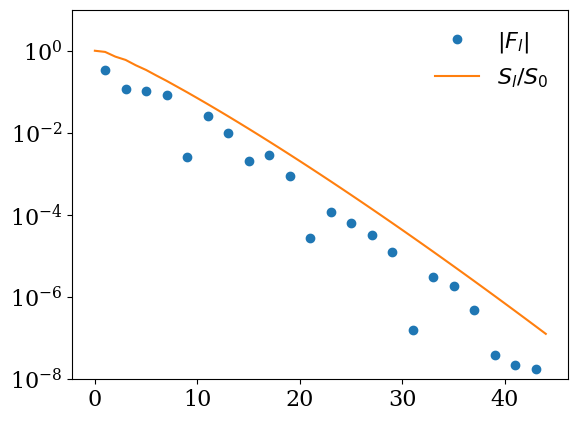

In [8]:
# Let us check `F` is represented compactly in IR
f_l = bset.smpl_wn_f.fit(res['f_iv'])
plt.semilogy(np.abs(f_l), label=r"$|F_l|$", marker="o", ls="")
plt.semilogy(bset.basis_f.s/bset.basis_f.s[0], label=r"$S_l/S_0$")
plt.ylim([1e-8, 10])
plt.legend(frameon=False)
plt.show()

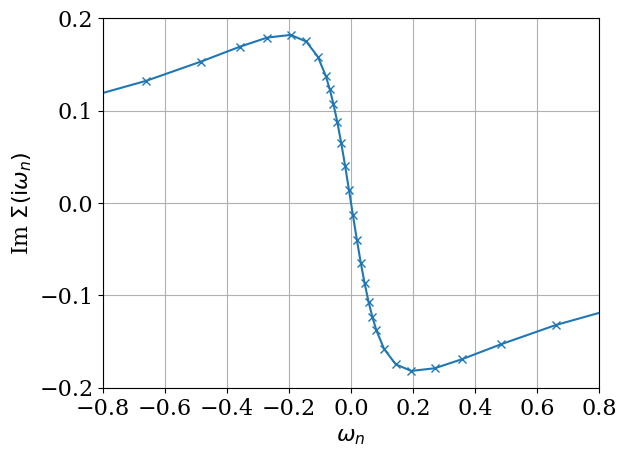

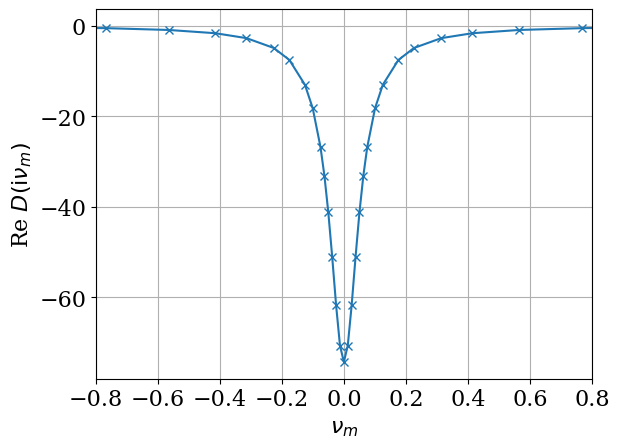

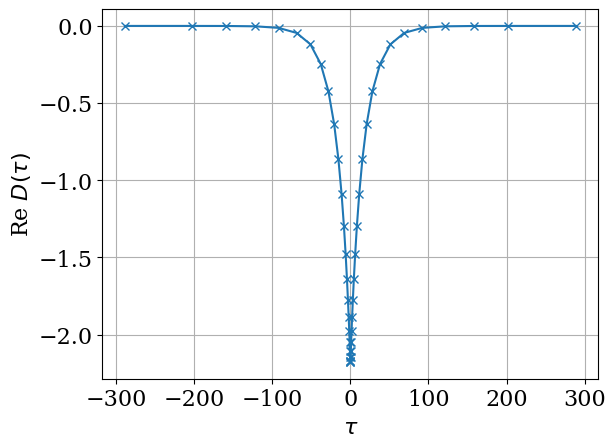

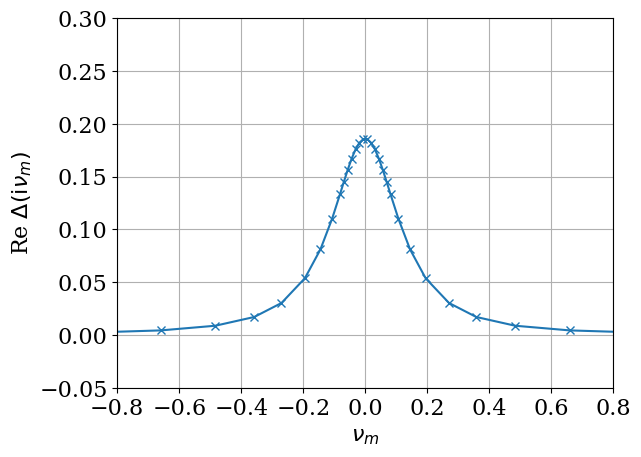

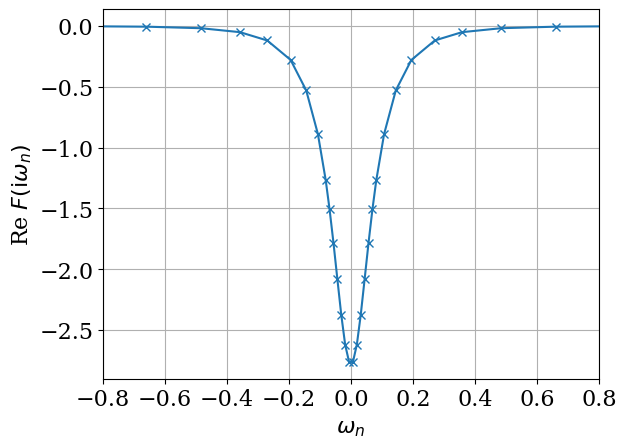

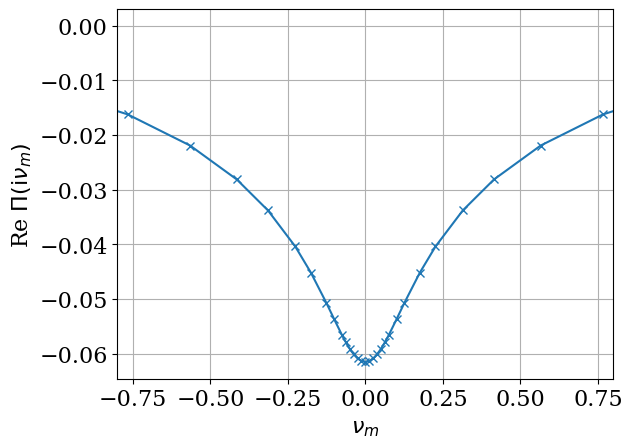

In [9]:
def plot_res(res):
    """ For plotting results """
    beta = res["bset"].beta
    iv_f = res["bset"].wn_f * (1j*np.pi/beta)
    iv_b = res["bset"].wn_b * (1j*np.pi/beta)

    plt.plot(iv_f.imag, res['sigma_iv'].imag, marker="x")
    plt.xlabel(r"$\omega_n$")
    plt.ylabel(r"Im $\Sigma(\mathrm{i}\omega_n)$")
    plt.xlim([-0.8, 0.8])
    plt.xticks([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
    plt.grid()
    plt.show()

    plt.plot(iv_b.imag, res['d_iv'].real, marker="x")
    plt.xlabel(r"$\nu_m$")
    plt.ylabel(r"Re $D(\mathrm{i}\nu_m)$")
    plt.xlim([-0.8, 0.8])
    plt.xticks([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
    #plt.ylim([-0.1, 0.1])
    plt.grid()
    plt.show()

    plt.plot(bset.tau, res['d_tau'].real, marker="x")
    plt.xlabel(r"$\tau$")
    plt.ylabel(r"Re $D(\tau)$")
    plt.grid()
    plt.show()

    plt.plot(iv_f.imag, res['delta_iv'].real, marker="x")
    plt.xlabel(r"$\nu_m$")
    plt.ylabel(r"Re $\Delta(\mathrm{i}\nu_m)$")
    plt.xlim([-0.8, 0.8])
    plt.xticks([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
    plt.ylim([-0.05, 0.3])
    plt.grid()
    plt.show()

    plt.plot(iv_f.imag, res['f_iv'].real, marker="x")
    plt.xlabel(r"$\omega_n$")
    plt.ylabel(r"Re $F(\mathrm{i}\omega_n)$")
    plt.xlim([-0.8, 0.8])
    plt.xticks([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
    plt.grid()
    plt.show()

    plt.plot(elsh.iv_b.imag, res['phi_iv'].real, marker="x")
    plt.xlabel(r"$\nu_m$")
    plt.ylabel(r"Re $\Pi(\mathrm{i}\nu_m)$")
    plt.xlim([-0.8, 0.8])
    plt.grid()
    plt.show()

plot_res(res)

In [10]:
lambda0 = 0.175
g = np.sqrt(3 * lambda0 * omega0/4)

In [11]:
res_temp = {}
temps = np.linspace(0.009, 0.013, 10)

# Set Lambda to a large enough value for the lowest temperature
Lambda_common = (10 * D)/temps.min()

# Shift the mesh points by dt, which doubles the mesh size,
# to compute the specific heat
dt = 1e-5
temps_all = np.unique(np.hstack((temps, temps + dt)))

bset = None
sigma_iv0 = None
elta_iv0  = None

for temp in temps_all:
    beta = 1/temp

    if bset is None:
        bset = sparse_ir.FiniteTempBasisSet(beta, Lambda_common/beta, eps)
    else:
        # Reuse the SVE results
        bset = sparse_ir.FiniteTempBasisSet(beta, Lambda_common/beta, eps, sve_result=bset.sve_result)

    elsh = Eliashberg(bset, rho_omega, (-D, D), U, J, omega0, g, deg_leggauss=deg_leggauss)

    # Initial guess
    if sigma_iv0 is None:
        noise = 1e-5
        sigma_iv0 = add_noise(np.zeros(bset.wn_f.size, dtype=np.complex128), noise)
        delta_iv0 = np.full(bset.wn_f.size, 1.0, dtype=np.complex128)

    # Solve!
    max_iter = 100000
    sigma_iv, delta_iv, others = solve(elsh, sigma_iv0, delta_iv0, max_iter, mixing, verbose=False, ph=True, atol=1e-6)
    res = {"sigma_iv": sigma_iv, "delta_iv": delta_iv}
    for k, v in others.items():
        res[k] = v
    res_temp[temp] = res

    # Use the converged result for an initial guess for the next temperature
    sigma_iv0 = res["sigma_iv"].copy()
    delta_iv0 = res["delta_iv"].copy()

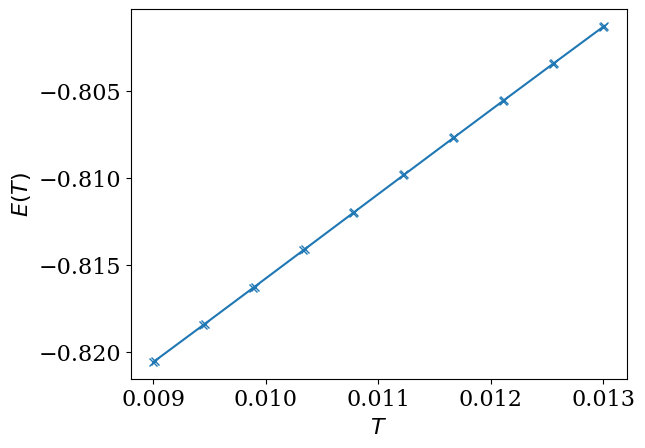

In [12]:
u_temps = np.array([res_temp[temp]["u"].real for temp in temps_all])
plt.plot(temps_all, u_temps, marker="x")
plt.xlabel(r"$T$")
plt.ylabel(r"$E(T)$")
plt.show()

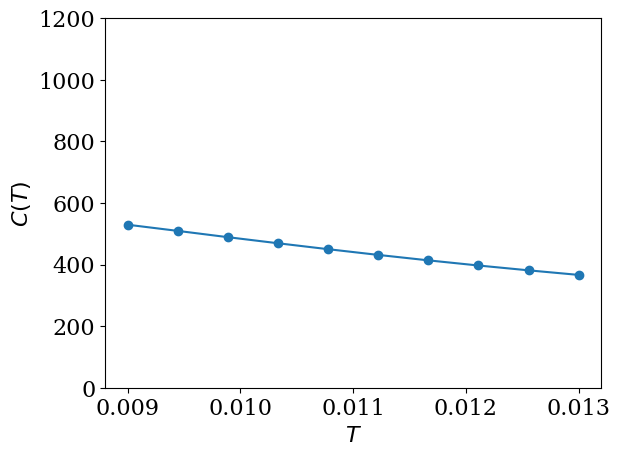

In [13]:
u_dict = {temp: res_temp[temp]["u"].real for temp in temps_all}
specific_heat = np.array([u_dict[temp+dt] - u_dict[temp] for temp in temps])/dt
plt.plot(temps, specific_heat/temps, marker="o")
plt.ylim([0, 1200])
plt.xlabel(r"$T$")
plt.ylabel(r"$C(T)$")
plt.show()